Best Response Sequences in the Iterated Prisoner's Dilemma
------------

This Chapter explores best response strategies, to a collection of opponents, in the form of sequences. The APL project is used to simulate matches between these opponents and the "sequence" players. Morespecifically, the class `Cycler` is used to simulate the sequences.

In [1]:
import sequence_sensei as ss
import pandas as pd
import dask
import axelrod as axl

import matplotlib.pyplot as plt
import numpy as np

//anaconda3/envs/rnn/lib/python3.6/site-packages/dask/config.py:129: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
dask.__version__

'0.18.1'

In [3]:
dask.delayed

<function delayed at 0x10e5019d8>

In [2]:
population = ss.get_initial_population(10)
opponent = axl.Random
seed=0

In [3]:
index_scores = []
for index, individual in enumerate(population):
    index_scores.append(
        ss.get_fitness_of_individual(
            individual, opponent, seed=seed, turns=200, index=index
        )
    )

In [4]:
index_scores[:3]

[Delayed('get_fitness_of_individual-9f797687-5e99-4579-9b7f-7a875a77f99f'),
 Delayed('get_fitness_of_individual-2d5dc4b9-b0e7-44d3-a097-063670ab0d0c'),
 Delayed('get_fitness_of_individual-2f09a095-2638-44da-81a8-86adaf728138')]

In [5]:
# scores = list(dask.compute(*index_scores, num_workers=3))
# scores

In [6]:
# results = [
#     [
#         opponent.name,
#         seed,
#         2000,
#         10,
#         0.1,
#         10,
#         2000,
#         *scores[i],
#         *population[i],
#     ]
#     for i in range(10* 2)
# ]
# results.sort(key=lambda tup: tup[8], reverse=True)
# pd.DataFrame(results)

In [7]:
jobs = [ss.get_fitness_of_individual(population[-1], axl.Random, seed=0, turns=200, index=19),
        ss.get_fitness_of_individual(population[-2], axl.Random, seed=0, turns=200, index=18)]

In [8]:
dask.compute(jobs,
             num_workers=2)

00 Random
 Random


([(19, 3.0), (18, 1.395)],)

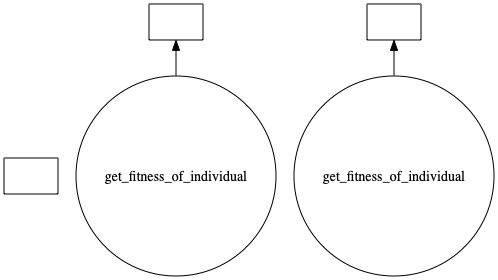

In [9]:
dask.visualize(dask.delayed()(jobs))

In [10]:
axl.seed(0)
opponent = axl.Random()
player = axl.Cycler(ss.get_sequence_str(population[-1]))
match = axl.Match([opponent, player], turns=200)
_ = match.play()

In [11]:
match.final_score_per_turn()[-1]

2.86

In [12]:
axl.seed(0)
opponent = axl.Random()
player = axl.Cycler(ss.get_sequence_str(population[-2]))
match = axl.Match([opponent, player], turns=200)
_ = match.play()
match.final_score_per_turn()[-1]

1.395

In [13]:
dask.compute([ss.get_fitness_of_individual(population[-1], axl.Random, seed=0, turns=200, index=19)],
             num_workers=4)

0 Random


([(19, 2.86)],)

**Investigating**

In [14]:
@dask.delayed
def get_random_number(seed):
    axl.seed(seed)
    return seed, [np.random.random() for _ in range(200)]
    

In [15]:
jobs = [get_random_number(0) for _ in range(10)]

In [16]:
expected_outcome_random_numbers = dask.compute(jobs, num_workers=4)

In [17]:
for _ in range(10000):
    assert dask.compute(jobs, num_workers=2) == expected_outcome_random_numbers

In [18]:
C, D = axl.Action.C, axl.Action.D

In [19]:
@dask.delayed
def get_random_interactions(seed):
    axl.seed(seed)
    players = [axl.Cooperator(), axl.Random()]
    match = axl.Match(players, turns=200)
    _ = match.play()
    
#     players[-1].reset()
    return seed, match.final_score_per_turn()[-1]
   

In [20]:
jobs = [get_random_interactions(0) for _ in range(10)]

In [22]:
dask.compute(*jobs, num_workers=4)

((0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.13))

In [23]:
expected_output_actions = ((0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07))

In [24]:
for i in range(1000):
    assert dask.compute(*jobs, num_workers=4) == expected_output_actions, f"Failed! at {i}"

AssertionError: Failed! at 1

In [25]:
axl.Random().reset()

**passing the player down**

In [106]:
def get_opponent_seed_combinations(opponent, number_of_seeds):
    experiment_values = []
    for seed in range(number_of_seeds):
        experiment_values.append((opponent, 0))
    return experiment_values

In [107]:
@dask.delayed
def get_random_interactions_passing_opponent(seed, opponent):
    axl.seed(seed)
    opponent = opponent()
    players = [axl.Cooperator(), opponent]
    match = axl.Match(players, turns=200)
    match.play()
    return seed, match.final_score_per_turn()[-1]
   

In [28]:
opponents = get_opponent_seed_combinations(axl.Random, number_of_seeds=10)

In [29]:
jobs = [get_random_interactions_passing_opponent(seed, player) for player, seed in opponents]

In [30]:
expected_output = ((0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07))

In [31]:
dask.compute(*jobs, num_workers=2)

((0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07),
 (0, 4.07))

In [32]:
for i in range(10000):
    assert dask.compute(*jobs, num_workers=4) == expected_output,  f"Failed! at {i}"

AssertionError: Failed! at 0

In [108]:
# An example that does not use `opponent=opponent()`
@dask.delayed
def get_random_interactions_passing_opponent_two(seed, opponent):
    (seed)
    player = opponent()
    players = [axl.Cooperator(), player]
    match = axl.Match(players, turns=200)
    match.play()
    return seed, match.final_score_per_turn()[-1]
   

In [34]:
opponents = get_opponent_seed_combinations(axl.Random, number_of_seeds=10)
jobs = [get_random_interactions_passing_opponent_two(seed, player) for player, seed in opponents]

In [35]:
for i in range(10000):
    assert dask.compute(*jobs, num_workers=4) == expected_output,  f"Failed! at {i}"

AssertionError: Failed! at 3

In [36]:
opponents[0][0]

axelrod.strategies.rand.Random

**Toby's example**

In [109]:
def get_seeded_player_class(player_class):
    class NewClass(player_class):
        def __init__(self, seed=0):
            self.my_seed = seed  # for pickling
            axl.seed(self.my_seed)
            super().__init__()

    return NewClass

In [110]:
opponents = [get_seeded_player_class(axl.Random)(seed=0) for _ in range(10)]

In [111]:
@dask.delayed
def get_random_interactions_passing_instance(seed, opponent):
    # axl.seed(seed) # both fail
#     print(opponent.my_seed)
    players = [axl.Cooperator(), opponent]
    match = axl.Match(players, turns=100)
    _ = match.play()
    
#     players[-1].reset()
    return match.final_score_per_turn()[-1], match.result

In [112]:
jobs = [get_random_interactions_passing_instance(0, player) for player in opponents]

In [113]:
output = dask.compute(*jobs, num_workers=4)

In [114]:
expected_scores = [out[0] for out in output]
expected_scores

[4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.02]

In [115]:
for i in range(10000):
    output = dask.compute(*jobs, num_workers=4)
    assert [out[0] for out in output] == expected_scores,  f"Failed! at {i}"

AssertionError: Failed! at 0

In [166]:
players = [get_seeded_player_class(axl.Random)(seed=0) for _ in range(2)]
for player in players:
    match = axl.Match([player, axl.Cooperator()], turns=10)
    _ = match.play()
    print(match.result)

[(D, C), (D, C), (C, C), (C, C), (D, C), (C, C), (D, C), (C, C), (C, C), (D, C)]
[(D, C), (D, C), (C, C), (C, C), (D, C), (C, C), (D, C), (C, C), (C, C), (D, C)]


In [125]:
[out[0] for out in output]

[4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26, 4.26]

In [126]:
output[7][0]

4.26

In [127]:
[actions[-1] for actions in output[7][1]] == [actions[-1] for actions in output[6][1]]

True

In [128]:
import axelrod.interaction_utils as iu
from axelrod.game import Game

In [171]:
def match(player_one, player_two, turns):
    results = []
    for _ in range(turns):
        s1 = player_one.strategy(player_two)
        s2 = player_two.strategy(player_one)

        player_one.history.append(s1)
        player_two.history.append(s2)
        results.append((s1, s2))
    return results

In [199]:
results = match(axl.Grudger(), axl.Alternator(), turns=10)
results

[(C, C),
 (C, D),
 (C, C),
 (C, D),
 (C, C),
 (C, D),
 (C, C),
 (C, D),
 (C, C),
 (C, D)]

In [197]:
results = match(axl.Random(), axl.Cooperator(), turns=10)
results

[(C, C),
 (D, C),
 (D, C),
 (C, C),
 (C, C),
 (C, C),
 (C, C),
 (C, C),
 (C, C),
 (C, C)]

In [174]:
results = match(get_seeded_player_class(axl.Random)(seed=1), axl.Cooperator(), turns=10)
results

[(C, C),
 (D, C),
 (D, C),
 (C, C),
 (C, C),
 (C, C),
 (D, C),
 (D, C),
 (C, C),
 (C, C)]

In [194]:
players = [get_seeded_player_class(axl.Random)(seed=1) for _ in range(2)]

In [195]:
for player in players:
    results = match(player, axl.Cooperator(), turns=10)
    print(results)

[(C, C), (D, C), (D, C), (C, C), (C, C), (C, C), (D, C), (D, C), (C, C), (C, C)]
[(D, C), (C, C), (D, C), (C, C), (C, C), (D, C), (C, C), (D, C), (D, C), (C, C)]


In [185]:
opponents = get_opponent_seed_combinations(axl.RandomTitForTat, number_of_seeds=10)

In [180]:
strategies = {strategy().name: strategy for strategy in axl.strategies 
              if strategy.classifier["stochastic"] == True}

In [182]:
results = match(axl.WorseAndWorse2(), axl.Cooperator(), turns=4)
results

[(C, C), (C, C), (C, C), (C, C)]

In [183]:
iu.compute_final_score_per_turn(results, Game())

(3.0, 3.0)

In [189]:
@dask.delayed
def get_my_class(opponent, seed):
    axl.seed(seed)
    results = match(opponent(), axl.Alternator(), turns=200)
    return iu.compute_final_score_per_turn(results, Game())

In [190]:
jobs = [get_my_class(player, seed) for player, seed in opponents]

In [191]:
expected_outcome = dask.compute(*jobs, num_workers=4)
expected_outcome

((2.13, 3.055),
 (2.13, 3.055),
 (2.13, 3.055),
 (2.13, 3.055),
 (2.13, 3.055),
 (2.13, 3.055),
 (2.13, 3.055),
 (2.13, 3.055),
 (2.13, 3.055),
 (2.13, 3.055))

In [193]:
for i in range(10000):
    assert dask.compute(*jobs, num_workers=4) == expected_outcome,  f"Failed! at {i}"

AssertionError: Failed! at 6618

In [2]:
import random
import scipy

In [228]:
np.random.get_state()[0]

'MT19937'

In [233]:
@dask.delayed
def get_random_interactions_numpy_seed(seed):
    np.random.seed(seed)
    players = [axl.Cooperator(), axl.Random()]
    match = axl.Match(players, turns=200)
    _ = match.play()

    return np.random.get_state(), seed, match.final_score_per_turn()[-1]

In [234]:
jobs = [get_random_interactions_numpy_seed(0) for _ in range(10)]

In [247]:
output = dask.compute(*jobs, num_workers=1)

In [248]:
[out[2] for out in output]

[4.06, 4.06, 4.06, 4.06, 4.06, 4.06, 4.06, 4.06, 4.06, 4.06]

In [249]:
states = [out[0] for out in output]

In [250]:
# states[0][1] == states[0][2]

In [223]:
for i in range(10000):
    assert dask.compute(*jobs, num_workers=2) == expected_outcome,  f"Failed! at {i}"

AssertionError: Failed! at 1360

In [58]:
np.random.RandomState()

RandomState(MT19937) at 0x121583490

In [152]:
from axelrod.action import Action
def random_choice(p, seed):
    """
    Return C with probability `p`, else return D

    No random sample is carried out if p is 0 or 1.

    Parameters
    ----------
    p : float
        The probability of picking C

    Returns
    -------
    axelrod.Action
    """
    if p == 0:
        return Action.D

    if p == 1:
        return Action.C
    
    R = np.random.RandomState(seed)
    r = R.random()
    if r < p:
        return Action.C
    return Action.D

In [179]:
from axelrod.action import Action
def random_choice(p, random_state=None):
    """
    Return C with probability `p`, else return D

    No random sample is carried out if p is 0 or 1.

    Parameters
    ----------
    p : float
        The probability of picking C

    Returns
    -------
    axelrod.Action
    """
    if p == 0:
        return Action.D

    if p == 1:
        return Action.C
    
    if random_state is None:
        r = np.random.random()
    else:
        R = random_state
        r = R.random()
    
    if r < p:
        return Action.C
    return Action.D

In [180]:
from axelrod.player import Player


class Random(Player):
    """A player who randomly chooses between cooperating and defecting.

    This strategy came 15th in Axelrod's original tournament.

    Names:

    - Random: [Axelrod1980]_
    - Lunatic: [Tzafestas2000]_
    """

    name = "Random"
    classifier = {
        "memory_depth": 0,  # Memory-one Four-Vector = (p, p, p, p)
        "stochastic": True,
        "makes_use_of": set(),
        "long_run_time": False,
        "inspects_source": False,
        "manipulates_source": False,
        "manipulates_state": False,
    }

    def __init__(self, p: float = 0.5, random_state=None) -> None:
        """
        Parameters
        ----------
        p, float
            The probability to cooperate

        Special Cases
        -------------
        Random(0) is equivalent to Defector
        Random(1) is equivalent to Cooperator
        """
        super().__init__()
        self.p = p 
        self.random_state = random_state

        if p in [0, 1]:
            self.classifier["stochastic"] = False

    def strategy(self, opponent: Player):
        return random_choice(self.p, self.random_state)


In [208]:
R = np.random.RandomState(0)
players = [axl.Cooperator(), Random(random_state=R)]

In [209]:
match = axl.Match(players, turns=200)
_ = match.play()
match.final_score_per_turn()

(1.41, 4.06)

In [343]:
@dask.delayed
def get_random_interactions_my_player(seed):
    R = np.random.RandomState(seed)
    players = [axl.Alternator(), Random(random_state=R)]
    match = axl.Match(players, turns=200)
    _ = match.play()

    return seed, match.final_score_per_turn()[-1]

In [344]:
jobs = [get_random_interactions_my_player(0) for _ in range(10)]

In [345]:
expected_outcome = dask.compute(*jobs, num_workers=1)
expected_outcome

((0, 2.31),
 (0, 2.31),
 (0, 2.31),
 (0, 2.31),
 (0, 2.31),
 (0, 2.31),
 (0, 2.31),
 (0, 2.31),
 (0, 2.31),
 (0, 2.31))

In [346]:
for i in range(10000):
    assert dask.compute(*jobs, num_workers=4) == expected_outcome,  f"Failed! at {i}"

In [ ]:
def pass_random_state_player_class(player_class):
    class NewClass(player_class):
        def __init__(self, seed=0):
            self.my_seed = seed  # for pickling
            axl.seed(self.my_seed)
            super().__init__()

    return NewClass

In [414]:
@dask.delayed
def get_random_choices(seed):
    axl.seed(seed)
    return [axl.random_choice(0.5) for _ in range(10)]

In [415]:
jobs = [get_random_choices(0) for _ in range(10)]

In [416]:
expected_outcome = dask.compute(*jobs, num_workers=4)
expected_outcome

([D, D, C, C, D, C, D, C, C, D],
 [D, D, C, C, D, C, D, C, C, D],
 [D, D, C, C, D, C, D, C, C, D],
 [D, D, C, C, D, C, D, C, C, D],
 [D, D, C, C, D, C, D, C, C, D],
 [D, D, C, C, D, C, D, C, C, D],
 [D, D, C, C, D, C, D, C, C, D],
 [D, D, C, C, D, C, D, C, C, D],
 [D, D, C, C, D, C, D, C, C, D],
 [D, D, C, C, D, C, D, C, C, D])

In [417]:
for i in range(10000):
#     output = dask.compute(*jobs, num_workers=4)
    assert dask.compute(*jobs, num_workers=4)  == expected_outcome,  f"Failed! at {i}"

In [276]:
player = axl.Random()

In [722]:
@dask.delayed
def get_random_interactions_passing_opponent(seed, opponent):
    axl.seed(seed)
    player = opponent()
    players = [axl.Cooperator(), player]
    match = axl.Match(players, turns=10)
    match.play()
    return seed, [actions[-1] for actions in match.result], match.final_score_per_turn()[-1]
   

In [723]:
opponents = get_opponent_seed_combinations(axl.Random, number_of_seeds=10)

In [724]:
jobs = [get_random_interactions_passing_opponent(seed, player) for player, seed in opponents]

In [731]:
dask.compute(*jobs, num_workers=4)

((0, [D, D, C, C, D, C, D, C, C, D], 4.0),
 (0, [D, D, C, C, D, C, D, C, C, D], 4.0),
 (0, [D, D, C, C, D, C, D, C, C, D], 4.0),
 (0, [D, D, C, C, D, C, D, C, C, D], 4.0),
 (0, [D, D, C, C, D, C, D, C, C, D], 4.0),
 (0, [D, D, C, C, D, C, D, C, C, D], 4.0),
 (0, [D, D, C, C, D, C, D, C, C, D], 4.0),
 (0, [D, D, C, C, D, C, D, C, C, D], 4.0),
 (0, [D, D, C, C, D, C, D, C, C, D], 4.0),
 (0, [D, D, C, C, D, C, D, C, C, D], 4.0))

**Try to implement seeding differently**

In [118]:
import numpy as np

def get_fitness_of_individual(sequence, opponent, seed, index, turns):
    """
    Returns the score of a sequence against a given opponent and the index
    of the sequence in the population.
    """
    axl.seed(seed)
    opponent = opponent()
    player = axl.Cycler(ss.get_sequence_str(sequence))
    match = axl.Match([opponent, player], turns=turns)
    match.play()

    return seed, index, match.final_score_per_turn()[-1]

In [119]:
index_scores = []
for index, individual in enumerate(population):
    index_scores.append(
        dask.delayed(get_fitness_of_individual)(
            individual, opponent, seed=seed, turns=200, index=index
        )
    )

In [120]:
index_scores[:5]

[Delayed('get_fitness_of_individual-bae51797-d3f4-4078-8e6a-f944cc83c5e2'),
 Delayed('get_fitness_of_individual-9b2ce02c-c331-45dd-9fd0-431411e72b66'),
 Delayed('get_fitness_of_individual-edfd0b58-aec3-46bd-93b2-9eace9ae6454'),
 Delayed('get_fitness_of_individual-502837ab-e80b-4da5-b64d-f53f2dc66fff'),
 Delayed('get_fitness_of_individual-8e7de3bc-1a36-4fc4-87d5-de1193419345')]

**Percentage of wrong sequences**

In [1]:
from pathlib import Path
import tqdm
import json

import axelrod as axl

import pandas as pd

import sequence_sensei as ss

//anaconda3/envs/rnn/lib/python3.6/site-packages/dask/config.py:129: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
strategies = {strategy().name: strategy for strategy in axl.strategies 
              if strategy.classifier["stochastic"] == True}

genes = ["gene_{}".format(i) for i in range(205)]

In [3]:
for file in tqdm.tqdm(Path("/Volumes/ext/Data/raw_data/").glob("*")):
    file

762it [00:00, 12423.36it/s]


In [4]:
file

PosixPath('/Volumes/ext/Data/raw_data/ZD-SET-2_9')

In [8]:
def run_seed_match_with_repetitions(seed, player, sequence, score, repetitions=5):
    for _ in range(repetitions):
        axl.seed(seed)
        match = axl.Match([player(), axl.Cycler(sequence)], turns=205)

        _ = match.play()
        
        check = score == match.final_score_per_turn()[-1]
        if check == False:
            return False
    return True

In [9]:
failed_names = []
checks = {}
for file in tqdm.tqdm(Path("/Volumes/ext/Data/raw_data/").glob("*")):
    file = str(file)
    if file.split('_')[-1] == 'nan':
        continue
    df = pd.read_csv(file + '/main.csv')
    df = df[df['generation'] == 2000]

    
    for i, row in df[df["score"] == df["score"].max()].reset_index().iterrows():
        try:
            opponent = strategies[row['opponent']]
        except KeyError:
            failed_names.append(row['opponent'])
            
        sequence = ss.get_sequence_str(row[genes].values)
        score = row['score']
        seed = int(row['seed'])
        
        check = run_seed_match_with_repetitions(seed=seed, player=opponent, sequence=sequence, score=score)
        
        key = row['opponent'] + '_' + str(seed) + '_best_response_' + str(i)
        checks[key] = check

with open('checks.txt', 'w') as file:
     file.write(json.dumps(checks))
        
with open('failed_names.txt', 'w') as file:
    file.write("\n".join(failed_names))

14it [02:10,  9.32s/it]

KeyboardInterrupt: 

In [10]:
checks

{'ALLCorALLD_0_best_response_0': False,
 'ALLCorALLD_1_best_response_0': True,
 'ALLCorALLD_1_best_response_1': True,
 'ALLCorALLD_1_best_response_10': True,
 'ALLCorALLD_1_best_response_11': True,
 'ALLCorALLD_1_best_response_12': True,
 'ALLCorALLD_1_best_response_13': True,
 'ALLCorALLD_1_best_response_14': True,
 'ALLCorALLD_1_best_response_15': True,
 'ALLCorALLD_1_best_response_16': True,
 'ALLCorALLD_1_best_response_17': True,
 'ALLCorALLD_1_best_response_18': True,
 'ALLCorALLD_1_best_response_19': True,
 'ALLCorALLD_1_best_response_2': True,
 'ALLCorALLD_1_best_response_20': True,
 'ALLCorALLD_1_best_response_21': True,
 'ALLCorALLD_1_best_response_22': True,
 'ALLCorALLD_1_best_response_23': True,
 'ALLCorALLD_1_best_response_24': True,
 'ALLCorALLD_1_best_response_25': True,
 'ALLCorALLD_1_best_response_26': True,
 'ALLCorALLD_1_best_response_27': True,
 'ALLCorALLD_1_best_response_28': True,
 'ALLCorALLD_1_best_response_29': True,
 'ALLCorALLD_1_best_response_3': True,
 'AL

'{"ALLCorALLD_4_best_response_0": true, "ALLCorALLD_4_best_response_1": true, "ALLCorALLD_4_best_response_2": true, "ALLCorALLD_4_best_response_3": true, "ALLCorALLD_4_best_response_4": true, "ALLCorALLD_4_best_response_5": true, "ALLCorALLD_4_best_response_6": true, "ALLCorALLD_4_best_response_7": true, "ALLCorALLD_4_best_response_8": true, "ALLCorALLD_4_best_response_9": true, "ALLCorALLD_4_best_response_10": true, "ALLCorALLD_4_best_response_11": true, "ALLCorALLD_4_best_response_12": true, "ALLCorALLD_4_best_response_13": true, "ALLCorALLD_4_best_response_14": true, "ALLCorALLD_4_best_response_15": true, "ALLCorALLD_4_best_response_16": true, "ALLCorALLD_4_best_response_17": true, "ALLCorALLD_4_best_response_18": true, "ALLCorALLD_4_best_response_19": true, "ALLCorALLD_4_best_response_20": true, "ALLCorALLD_4_best_response_21": true, "ALLCorALLD_4_best_response_22": true, "ALLCorALLD_4_best_response_23": true}'

In [340]:
len(checks)

7851

In [342]:
sum(checks) / len(checks)

0.47025856578779773

In [264]:
sizes = [20, 30, 40]

In [263]:
constant = 18 / 3

In [265]:
sum([size * constant for size in sizes])

540.0